In [3]:
### ====> https://www.tensorflow.org/install/pip#windows-native_1
### ====> conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0


# Ja, je kunt (bijna) alle onderstaande packages installeren met pip:
# Gebruik in je terminal/command prompt:
# pip install numpy pandas matplotlib tensorflow scikit-learn keras keras-tuner

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, callbacks, preprocessing
from sklearn.model_selection import train_test_split 
from keras.layers import Input, Dense, Conv1D, Flatten
from keras.models import Model, Sequential
from sklearn.preprocessing import MinMaxScaler
import keras
import keras_tuner as kt

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.test.is_gpu_available()

Num GPUs Available:  0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# GPU instellen

In [4]:
gpus = tf.config.list_physical_devices('GPU')
print("Beschikbare GPU(s):", gpus)

tf.test.is_gpu_available()

strategy = tf.distribute.MirroredStrategy(devices=["/gpu:1"])
print("Aantal GPU's:", strategy.num_replicas_in_sync)




Beschikbare GPU(s): []
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:1',)
Aantal GPU's: 1


# CSV Import en het Plotten/uitlezen van de CSV

   Tijd (s)  Setpoint (m)  Hoogte (m)      Fout  Fout_Integratie  \
0      0.00      0.700171    0.004019  0.700171         0.007002   
1      0.01      0.700171    0.012057  0.696152         0.013963   
2      0.02      0.700171    0.024114  0.688114         0.020844   
3      0.03      0.700171    0.040190  0.676057         0.027605   
4      0.04      0.700171    0.060285  0.659981         0.034205   

   Fout_Afgeleide  PWM  
0       70.017086  1.0  
1       -0.401900  1.0  
2       -0.803800  1.0  
3       -1.205700  1.0  
4       -1.607600  1.0  
Index(['Tijd (s)', 'Setpoint (m)', 'Hoogte (m)', 'Fout', 'Fout_Integratie',
       'Fout_Afgeleide', 'PWM'],
      dtype='object')
            Tijd (s)   Setpoint (m)     Hoogte (m)           Fout  \
count  100002.000000  100002.000000  100002.000000  100002.000000   
mean      500.005000       0.521598       0.521455       0.000148   
std       288.682351       0.273731       0.277757       0.047845   
min         0.000000       0.06126

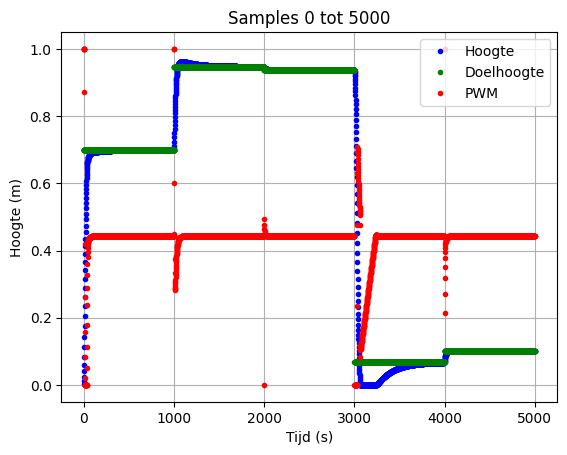

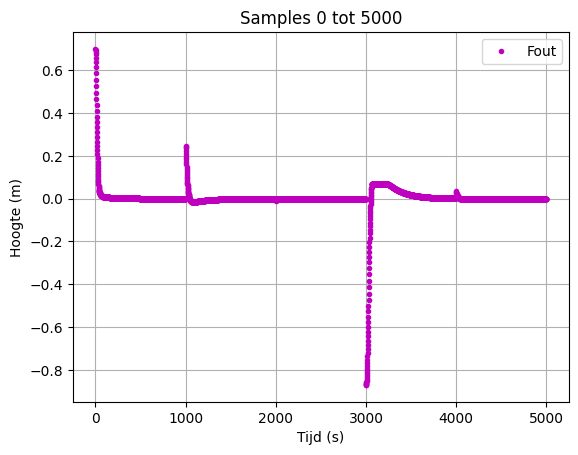

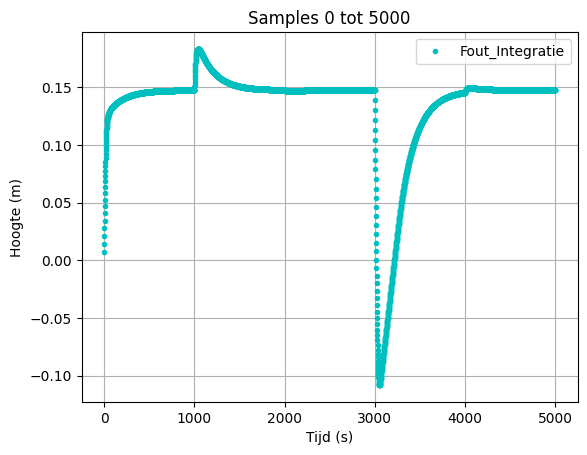

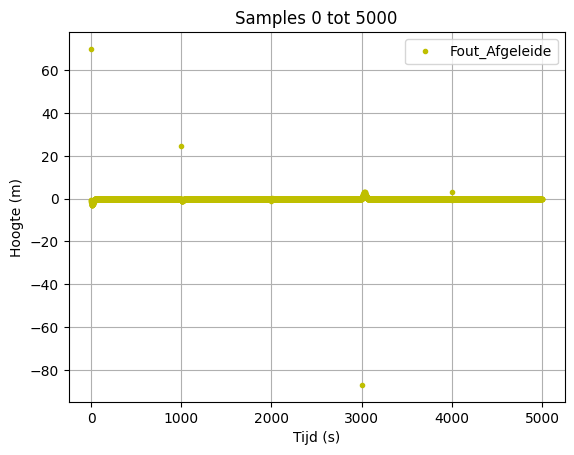

In [5]:
CSV_PATH = '/Users/mitchelreints/Documents/GitHub/PEE51---AIRegelsysteem/simulatie_resultaten_101_20250614_224926.csv'
CSV_DATA = pd.read_csv(CSV_PATH)
print(CSV_DATA.head())
print(CSV_DATA.columns)
print(CSV_DATA.describe())
print(CSV_DATA.info())
print(CSV_DATA.shape)
print(CSV_DATA.dtypes)
print(CSV_DATA.isnull().sum())
print(CSV_DATA.nunique())
print(CSV_DATA.memory_usage(deep=True))
print(CSV_DATA)

# Toon aantal samples
total_samples = len(CSV_DATA)
print(f"Aantal samples: {total_samples}")
print(f"Indexbereik: 0 t/m {total_samples - 1}")

# Dynamisch start en end kiezen
start = 0
end = min(5000, total_samples)

# Veiligheidscheck
if end > start:
    x_range = range(start, end)

    plt.figure()
    plt.plot(x_range, CSV_DATA["Hoogte (m)"][start:end], 'b.', label="Hoogte")
    plt.plot(x_range, CSV_DATA["Setpoint (m)"][start:end], 'g.', label="Doelhoogte")
    plt.plot(x_range, CSV_DATA["PWM"][start:end], 'r.', label="PWM")
    plt.title(f"Samples {start} tot {end}")
    plt.xlabel("Tijd (s)")
    plt.ylabel("Hoogte (m)")
    plt.grid(True)
    plt.legend()

    plt.figure()
    plt.plot(x_range, CSV_DATA["Fout"][start:end], 'm.', label="Fout")
    plt.title(f"Samples {start} tot {end}")
    plt.xlabel("Tijd (s)")
    plt.ylabel("Hoogte (m)")
    plt.grid(True)
    plt.legend()

    plt.figure()
    plt.plot(x_range, CSV_DATA["Fout_Integratie"][start:end], 'c.', label="Fout_Integratie")
    plt.title(f"Samples {start} tot {end}")
    plt.xlabel("Tijd (s)")
    plt.ylabel("Hoogte (m)")
    plt.grid(True)
    plt.legend()

    plt.figure()
    plt.plot(x_range, CSV_DATA["Fout_Afgeleide"][start:end], 'y.', label="Fout_Afgeleide")
    plt.title(f"Samples {start} tot {end}")
    plt.xlabel("Tijd (s)")
    plt.ylabel("Hoogte (m)")
    plt.grid(True)
    plt.legend()

    plt.show()
else:
    print("⚠️ Niet genoeg samples om in dit bereik te plotten.")

# CSV verbinden met input/output trainset

In [6]:
# Selecteer features en target
features = CSV_DATA[['Setpoint (m)', 'Hoogte (m)', 'Fout', 'Fout_Integratie', 'Fout_Afgeleide']].to_numpy()
target = CSV_DATA['PWM'].to_numpy()

# Normaliseer alleen de features
# feature_scaler = MinMaxScaler()
# features = feature_scaler.fit_transform(features_raw)

# Print informatie
print(f"Features shape: {features.shape}")
print(f"Target shape: {target.shape}\n")

print("🔹 Originele features (eerste 5 samples):")
print(features[:5])

print("\n🔸 Genormaliseerde features (eerste 5 samples):")
print(features[:5])

print("\n🎯 Target (eerste 5 waarden):")
print(target[:5])

# Voor inverse transform later:
# originele_features = feature_scaler.inverse_transform(features)

Features shape: (100002, 5)
Target shape: (100002,)

🔹 Originele features (eerste 5 samples):
[[ 7.0017100e-01  4.0190000e-03  7.0017100e-01  7.0020000e-03
   7.0017086e+01]
 [ 7.0017100e-01  1.2057000e-02  6.9615200e-01  1.3963000e-02
  -4.0190000e-01]
 [ 7.0017100e-01  2.4114000e-02  6.8811400e-01  2.0844000e-02
  -8.0380000e-01]
 [ 7.0017100e-01  4.0190000e-02  6.7605700e-01  2.7605000e-02
  -1.2057000e+00]
 [ 7.0017100e-01  6.0285000e-02  6.5998100e-01  3.4205000e-02
  -1.6076000e+00]]

🔸 Genormaliseerde features (eerste 5 samples):
[[ 7.0017100e-01  4.0190000e-03  7.0017100e-01  7.0020000e-03
   7.0017086e+01]
 [ 7.0017100e-01  1.2057000e-02  6.9615200e-01  1.3963000e-02
  -4.0190000e-01]
 [ 7.0017100e-01  2.4114000e-02  6.8811400e-01  2.0844000e-02
  -8.0380000e-01]
 [ 7.0017100e-01  4.0190000e-02  6.7605700e-01  2.7605000e-02
  -1.2057000e+00]
 [ 7.0017100e-01  6.0285000e-02  6.5998100e-01  3.4205000e-02
  -1.6076000e+00]]

🎯 Target (eerste 5 waarden):
[1. 1. 1. 1. 1.]


In [7]:
n_input = 2  # aantal tijdstappen per voorbeeld

X, y = [], []

for i in range(len(features) - n_input):
    X.append(features[i:i + n_input])
    y.append(target[i + n_input])  # de PWM bij het volgende moment

X = np.array(X)  # shape: (samples, n_input, features)
y = np.array(y)

print("X shape:", X.shape)  # (samples, tijdstappen, features)
print("y shape:", y.shape)  # (samples,)
print("X:", X)  # (samples, tijdstappen, features)
print("y:", y) 

X shape: (100000, 2, 5)
y shape: (100000,)
X: [[[ 7.0017100e-01  4.0190000e-03  7.0017100e-01  7.0020000e-03
    7.0017086e+01]
  [ 7.0017100e-01  1.2057000e-02  6.9615200e-01  1.3963000e-02
   -4.0190000e-01]]

 [[ 7.0017100e-01  1.2057000e-02  6.9615200e-01  1.3963000e-02
   -4.0190000e-01]
  [ 7.0017100e-01  2.4114000e-02  6.8811400e-01  2.0844000e-02
   -8.0380000e-01]]

 [[ 7.0017100e-01  2.4114000e-02  6.8811400e-01  2.0844000e-02
   -8.0380000e-01]
  [ 7.0017100e-01  4.0190000e-02  6.7605700e-01  2.7605000e-02
   -1.2057000e+00]]

 ...

 [[ 4.7636900e-01  4.7639700e-01 -2.8000000e-05  1.4769900e-01
    1.5000000e-05]
  [ 4.7636900e-01  4.7639600e-01 -2.8000000e-05  1.4769800e-01
    1.5000000e-05]]

 [[ 4.7636900e-01  4.7639600e-01 -2.8000000e-05  1.4769800e-01
    1.5000000e-05]
  [ 4.7636900e-01  4.7639600e-01 -2.7000000e-05  1.4769800e-01
    1.5000000e-05]]

 [[ 4.7636900e-01  4.7639600e-01 -2.7000000e-05  1.4769800e-01
    1.5000000e-05]
  [ 4.7636900e-01  4.7639600e-01 -2.

# het Splitten van de Trainingset en Testset en het weergeven van de Testset op de Trainingset

Test range: index 3000–22999
Train samples: 80000
Test samples: 20000


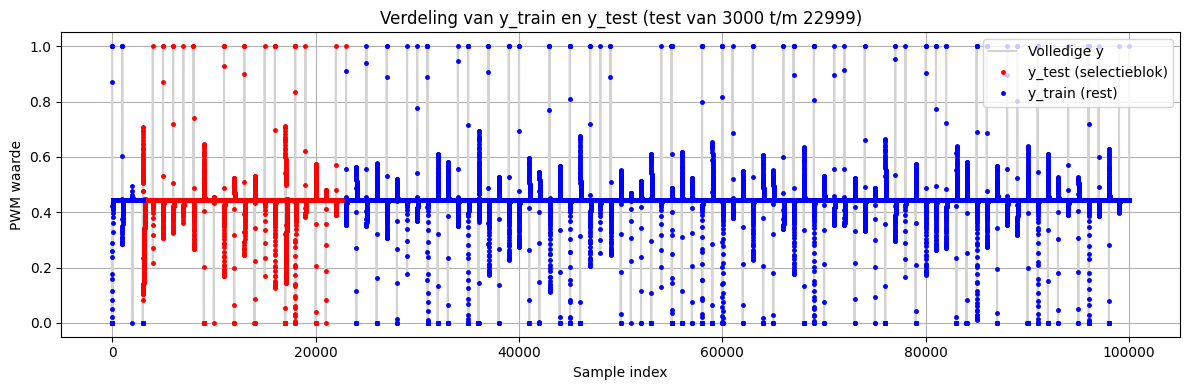

In [8]:
# Lengte van dataset
n = len(y)

# Hoeveel samples is 20%
test_len = int(n * 0.2)

# Kies handmatig waar je testdata begint
test_start = 3000  # bijvoorbeeld index 3000
test_end = test_start + test_len

# Zorg dat je niet buiten de dataset gaat
assert test_end <= n, "Testblok gaat buiten dataset!"

# Slice y en X
X_test, y_test = X[test_start:test_end], y[test_start:test_end]
X_train = np.concatenate((X[:test_start], X[test_end:]), axis=0)
y_train = np.concatenate((y[:test_start], y[test_end:]), axis=0)

print(f"Test range: index {test_start}–{test_end-1}")
print(f"Train samples: {len(y_train)}")
print(f"Test samples: {len(y_test)}")


import matplotlib.pyplot as plt

full_indices = np.arange(len(y))
idx_test = np.arange(test_start, test_end)
idx_train = np.setdiff1d(full_indices, idx_test)

plt.figure(figsize=(12, 4))
plt.plot(full_indices, y, color='lightgray', label="Volledige y")
plt.plot(idx_test, y_test, 'r.', label="y_test (selectieblok)", markersize=5)
plt.plot(idx_train, y_train, 'b.', label="y_train (rest)", markersize=5)

plt.title(f"Verdeling van y_train en y_test (test van {test_start} t/m {test_end - 1})")
plt.xlabel("Sample index")
plt.ylabel("PWM waarde")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Model Aanmaken en compilen met GPU

In [9]:
# with strategy.scope():
#     model = Sequential([
#     Conv1D(filters=16, kernel_size=2, activation='relu', input_shape=(n_input, X.shape[2])),  # 8 filters
#     Flatten(),
#     Dense(56, activation='sigmoid'),  # Hidden layer 1
#     Dense(12, activation='sigmoid'),  # Hidden layer 2
#     Dense(1)  # Output layer met 8 neuronen
# ])
#     model.compile(optimizer='adam', loss='mse')
    


# Model Aanmaken (Standaard Versie)

In [10]:
# model = Sequential([
#     Conv1D(filters=16, kernel_size=2, activation='relu', input_shape=(n_input, X.shape[2])),  # 8 filters
#     Flatten(),
#     Dense(56, activation='sigmoid'),  # Hidden layer 1
#     Dense(12, activation='sigmoid'),  # Hidden layer 2
#     Dense(1)  # Output layer met 8 neuronen
# ])

# model = Sequential([
#     Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(n_input, X.shape[2])),
#     Flatten(),
#     Dense(64, activation='relu'),
#     Dense(1)  # Één PWM-waarde voorspellen
# ])

model = Sequential([
    Conv1D(filters=8, kernel_size=2, activation='relu', input_shape=(n_input, X.shape[2])),  # 8 filters
    Flatten(),
    Dense(56, activation='sigmoid'),  # Hidden layer 1
    Dense(12, activation='sigmoid'),  # Hidden layer 2
    Dense(1)  # Output layer met 8 neuronen
])

print("n_input:", n_input)
print("X.shape[2]:", X.shape[2])
model.summary()

n_input: 2
X.shape[2]: 5


/Users/mitchelreints/Documents/GitHub/PEE51---AIRegelsysteem/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 8)           │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 56)             │           504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           684 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,289 (5.04 KB)

 Trainable params: 1,289 (5.04 KB)

 Non-trainable params: 0 (0.00 B)

# Model aanmaken (Fine Tuning)

In [11]:
# def model_builder(hp):
#     model = Sequential()

#     # Conv1D laag met tunable filters en kernel size
#     model.add(Conv1D(
#     filters=hp.Int('filters', 4, 32, step=4),
#     kernel_size=hp.Int('kernel_size', 1, min(n_input, 5), step=1),  # max kernel_size aangepast aan input
#     activation=hp.Choice('conv_activation', ['relu', 'tanh', 'sigmoid']),
#     padding='same',  # voorkomt output <= 0
#     input_shape=(n_input, X.shape[2])
# ))


#     model.add(Flatten())

#     # Hidden Dense layer 1
#     model.add(Dense(
#         units=hp.Int('dense1_units', min_value=4, max_value=64, step=4),
#         activation=hp.Choice('dense1_activation', values=['relu', 'tanh', 'sigmoid'])
#     ))

#     # Hidden Dense layer 2
#     model.add(Dense(
#         units=hp.Int('dense2_units', min_value=4, max_value=64, step=4),
#         activation=hp.Choice('dense2_activation', values=['relu', 'tanh', 'sigmoid'])
#     ))

#     # Output layer (voor regressie zonder activatie of 'sigmoid'/'softmax' voor classificatie)
#     model.add(Dense(1))

#     # Learning rate als hyperparameter
#     hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
#         loss='mse',  # pas aan als je classificatie doet
#         metrics=['mae']  # pas aan indien nodig
#     )

#     return model

# Model Fine tuning

In [12]:
# tuner = kt.RandomSearch(
#     model_builder,
#     objective='val_mae',  # of 'val_accuracy' bij classificatie
#     max_trials=10,
#     executions_per_trial=1,
#     directory='my_dir',
#     project_name='cnn_dense_tuning'
# )

# tuner.search(X_train, y_train, epochs=1, validation_split=0.2)

# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# print(f"""
# Beste Conv1D filters: {best_hps.get('filters')}
# Beste kernel_size: {best_hps.get('kernel_size')}
# Activatie Conv: {best_hps.get('conv_activation')}
# Dense1: {best_hps.get('dense1_units')} units, activatie: {best_hps.get('dense1_activation')}
# Dense2: {best_hps.get('dense2_units')} units, activatie: {best_hps.get('dense2_activation')}
# Learning rate: {best_hps.get('learning_rate')}
# """)


# Model Compilen (Standaard Versie)

In [13]:
model.compile(optimizer='adam', loss='mse')

# Model Trainen

In [14]:

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# model = tuner.hypermodel.build(best_hps)

# history = model.fit(
#     X_train,
#     y_train,
#     epochs=5,
#     batch_size=32,
#     validation_data=(X_test, y_test)
# )

Epoch 1/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 405us/step - loss: 0.0413 - val_loss: 0.0016
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 391us/step - loss: 9.8950e-04 - val_loss: 0.0011
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 376us/step - loss: 6.3847e-04 - val_loss: 8.6815e-04
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 436us/step - loss: 4.8780e-04 - val_loss: 6.8460e-04
Epoch 5/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 381us/step - loss: 4.2504e-04 - val_loss: 6.7830e-04
Epoch 6/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 376us/step - loss: 4.3213e-04 - val_loss: 6.5165e-04
Epoch 7/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 381us/step - loss: 3.8564e-04 - val_loss: 6.0284e-04
Epoch 8/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 376us/step - loss: 3.4605e-04 - val_loss: 5.6846e-04
Epoch 9/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 375us/step - loss: 3.6523e-04 - val_loss: 6.0660e-04
Epoch 10/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 379us/step - loss: 3.8790e-04 - val_loss: 5.3281e-04
Epoch 11/50
2500/2500 ━━━━━━━━━

# Training en validation loss Plotten

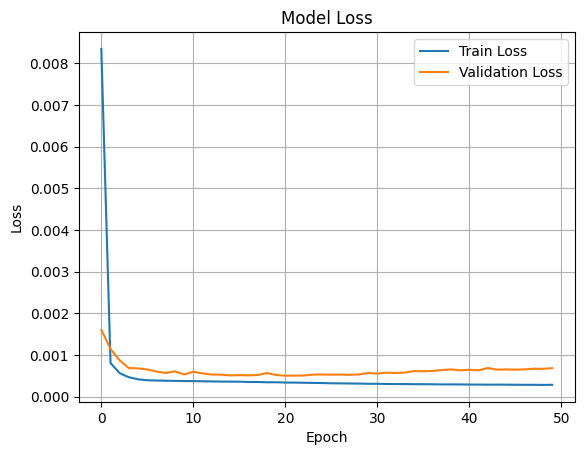

In [15]:
# Plot the training history
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(loss) + 1)


# Plot loss
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

# Predict

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step - loss: 0.0016

loss : 0.0006825110176578164
y_test heeft 20000 samples (indexbereik: 0 t/m 19999)


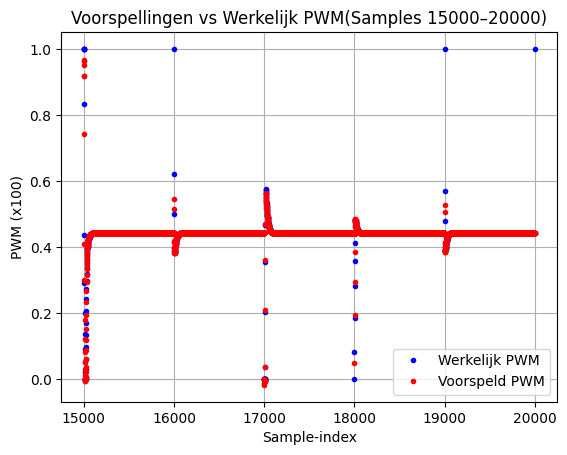

In [25]:
# Maak voorspellingen
predictions = model.predict(X_test).flatten()

score = model.evaluate(X_test, y_test)
print(f"\n{model.metrics_names[0]} : {score}")

print(f"y_test heeft {len(y_test)} samples (indexbereik: 0 t/m {len(y_test) - 1})")

# Stel de range in
start = 15000
end = min(20000, len(y_test)) 

# Plot alleen het gewenste bereik
plt.figure()
plt.title(f"Voorspellingen vs Werkelijk PWM(Samples {start}–{end})")
plt.plot(range(start, end), y_test[start:end], 'b.', label='Werkelijk PWM')
plt.plot(range(start, end), predictions[start:end], 'r.', label='Voorspeld PWM')
plt.xlabel("Sample-index")
plt.ylabel("PWM (x100)")
plt.legend()
plt.grid(True)

plt.show()


# Tflite model Export

In [17]:
model.export("model")  # Exporteer als TensorFlow SavedModel voor TFLite

converter = tf.lite.TFLiteConverter.from_saved_model("model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

tflite_model = converter.convert()
with open("model.tflite", "wb") as f:
    f.write(tflite_model)
print("✅ Model succesvol getraind en geconverteerd (.tflite)")

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


Saved artifact at 'model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 2, 5), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  12892284080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12892848544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12892852768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12892852416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12892853648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12892855584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12892856992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12892856288: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ Model succesvol getraind en geconverteerd (.tflite)


W0000 00:00:1750280012.697545 4297976 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1750280012.697575 4297976 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-06-18 22:53:32.698049: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: model
2025-06-18 22:53:32.698346: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-06-18 22:53:32.698350: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: model
I0000 00:00:1750280012.700826 4297976 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-06-18 22:53:32.701293: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-06-18 22:53:32.718033: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: model
2025-06-18 22:53:32.723389: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: 